In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")

import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv2D,Conv1D, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import backend as K



# Set random seed for reproducibility
tf.random.set_seed(42)

In [2]:
!pip install Historic-Crypto

In [3]:
import warnings
warnings.filterwarnings("ignore")

from Historic_Crypto import HistoricalData

In [4]:
btc_historicals = HistoricalData('BTC-USD',86400,'2017-01-01-00-00', '2021-01-01-00-00').retrieve_data() # cyrpto name, number of seconds, start date, end date


Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2017-01-01T00:00:00
Provisional End: 2017-10-28T00:00:00
Data for chunk 1 of 5 extracted
Provisional Start: 2017-10-28T00:00:00
Provisional End: 2018-08-24T00:00:00
Data for chunk 2 of 5 extracted
Provisional Start: 2018-08-24T00:00:00
Provisional End: 2019-06-20T00:00:00
Data for chunk 3 of 5 extracted
Provisional Start: 2019-06-20T00:00:00
Provisional End: 2020-04-15T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2020-04-15T00:00:00
Provisional End: 2021-02-09T00:00:00
Data for chunk 5 of 5 extracted


In [5]:
btc_historicals.shape

(1461, 5)

In [6]:
btc_historicals.tail()

,low,high,open,close,volume
time,,,,,
2020-12-28,26086.19,27477.00,26255.16,27040.36,21265.709350
2020-12-29,25833.73,27396.77,27039.39,27366.35,20668.104338
2020-12-30,27311.73,29018.26,27366.35,28897.42,28181.496815
2020-12-31,28000.00,29321.90,28897.42,28990.08,28813.886911
2021-01-01,28700.00,29688.88,28990.08,29412.84,22211.252518


In [7]:
# Check out variables
btc_historicals.dtypes

low       float64
high      float64
open      float64
close     float64
volume    float64
dtype: object

In [8]:
tst = btc_historicals

In [9]:
print('Null Values:',tst.isnull().values.sum())
print('If any NA values:', tst.isnull().values.any())

Null Values: 0
If any NA values: False


In [10]:
# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1
tst['TOMORROW_CLOSE'] = tst['close'].shift(-1,fill_value=0)

In [11]:
# drop last row because we shifted value (remember this when you add your forecasting data)
tst.drop(tst.tail(1).index,inplace=True) 

In [12]:
# Drop close column, since we created new ‘TOMORROW_CLOSE’
tst = tst.drop(columns=['close'])

In [13]:
tst.head()

,low,high,open,volume,TOMORROW_CLOSE
time,,,,,
2017-01-02,990.52,1034.39,992.96,7723.635752,1020.67
2017-01-03,1006.71,1036.99,1011.52,8615.260058,1130.30
2017-01-04,1018.00,1147.00,1020.69,16222.230267,1007.00
2017-01-05,880.00,1175.00,1131.10,20446.405615,895.71
2017-01-06,875.01,1033.85,1007.00,14274.259206,909.00


In [14]:
tst.shape

(1460, 5)

In [15]:
# Split train data (90%) and test data (10%)

train_size = int(len(tst)*0.90)
train_dataset, test_dataset = tst.iloc[:train_size],tst.iloc[train_size:]


In [16]:
train_dataset.head()

,low,high,open,volume,TOMORROW_CLOSE
time,,,,,
2017-01-02,990.52,1034.39,992.96,7723.635752,1020.67
2017-01-03,1006.71,1036.99,1011.52,8615.260058,1130.30
2017-01-04,1018.00,1147.00,1020.69,16222.230267,1007.00
2017-01-05,880.00,1175.00,1131.10,20446.405615,895.71
2017-01-06,875.01,1033.85,1007.00,14274.259206,909.00


In [17]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [18]:
X_train.head()

,low,high,open,volume
time,,,,
2017-01-02,990.52,1034.39,992.96,7723.635752
2017-01-03,1006.71,1036.99,1011.52,8615.260058
2017-01-04,1018.00,1147.00,1020.69,16222.230267
2017-01-05,880.00,1175.00,1131.10,20446.405615
2017-01-06,875.01,1033.85,1007.00,14274.259206


Dimension of train data:  (1314, 5)
Dimension of test data:  (146, 5)


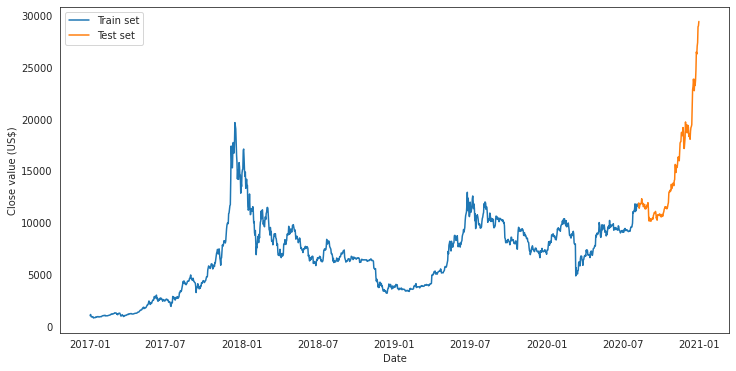

In [19]:
#Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


In [20]:
# Different scaler for input and output ----> Normalizate the data
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [21]:
# Create 3 dimensional data set 
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10 # which means the model will make predictions of ‘TOMORROW_CLOSE’ based on the input from the 10 previous days or future days bi-lstm or bi-gru

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1304, 10, 4)
y_train.shape:  (1304, 1)
X_test.shape:  (136, 10, 4)
y_test.shape:  (136, 1)


In [22]:
# Create LSTM 
def create_model(m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = 32, activation = 'relu', return_sequences = False, input_shape = [X_train.shape[1], X_train.shape[2]])) # use 64 hidden units
    model.add(Dropout(0.2)) # dropout for regulaization, with probability of 20% 
    model.add(Dense(units = 1)) 
    model.add(BatchNormalization())
    #Compile model
    model.compile(loss = 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001 ) ) # use loss as MSE and Adam optimizer
    return model

In [23]:
model_lstm = create_model(LSTM)


In [24]:
# Let's check the summary of our baby model
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 batch_normalization (BatchN  (None, 1)                4         
 ormalization)                                                   
                                                                 
Total params: 4,773
Trainable params: 4,771
Non-trainable params: 2
_________________________________________________________________


In [25]:
# Fit the model !
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15) # use early stop technique to stop the training process if the val loss didn't improve for 10 epochs

# decaying lr on every 2nd epoch by 1%
def scheduler(epoch, lr):
    rate =  1 - 0.01 
    if epoch%2 == 0:
        return lr*rate
    return lr

LRscheduler = LearningRateScheduler(scheduler)
callbacks_list = [early_stop, LRscheduler]
history_lstm = model_lstm.fit(X_train, y_train, epochs = 120, validation_split = 0.2,batch_size = 32, shuffle = False,callbacks=callbacks_list) # no shuffer , as its time series data

Epoch 1/120
33/33 [==============================] - 6s 104ms/step - loss: 1.0821 - val_loss: 0.0305 - lr: 9.9000e-04
Epoch 2/120
33/33 [==============================] - 3s 90ms/step - loss: 0.7339 - val_loss: 0.0398 - lr: 9.9000e-04
Epoch 3/120
33/33 [==============================] - 3s 78ms/step - loss: 0.4430 - val_loss: 0.0413 - lr: 9.8010e-04
Epoch 4/120
33/33 [==============================] - 3s 79ms/step - loss: 0.3091 - val_loss: 0.0342 - lr: 9.8010e-04
Epoch 5/120
33/33 [==============================] - 2s 73ms/step - loss: 0.2562 - val_loss: 0.0299 - lr: 9.7030e-04
Epoch 6/120
33/33 [==============================] - 3s 80ms/step - loss: 0.2407 - val_loss: 0.0228 - lr: 9.7030e-04
Epoch 7/120
33/33 [==============================] - 3s 80ms/step - loss: 0.2262 - val_loss: 0.0206 - lr: 9.6060e-04
Epoch 8/120
33/33 [==============================] - 3s 88ms/step - loss: 0.2140 - val_loss: 0.0190 - lr: 9.6060e-04
Epoch 9/120
33/33 [==============================] - 3s 81ms/st

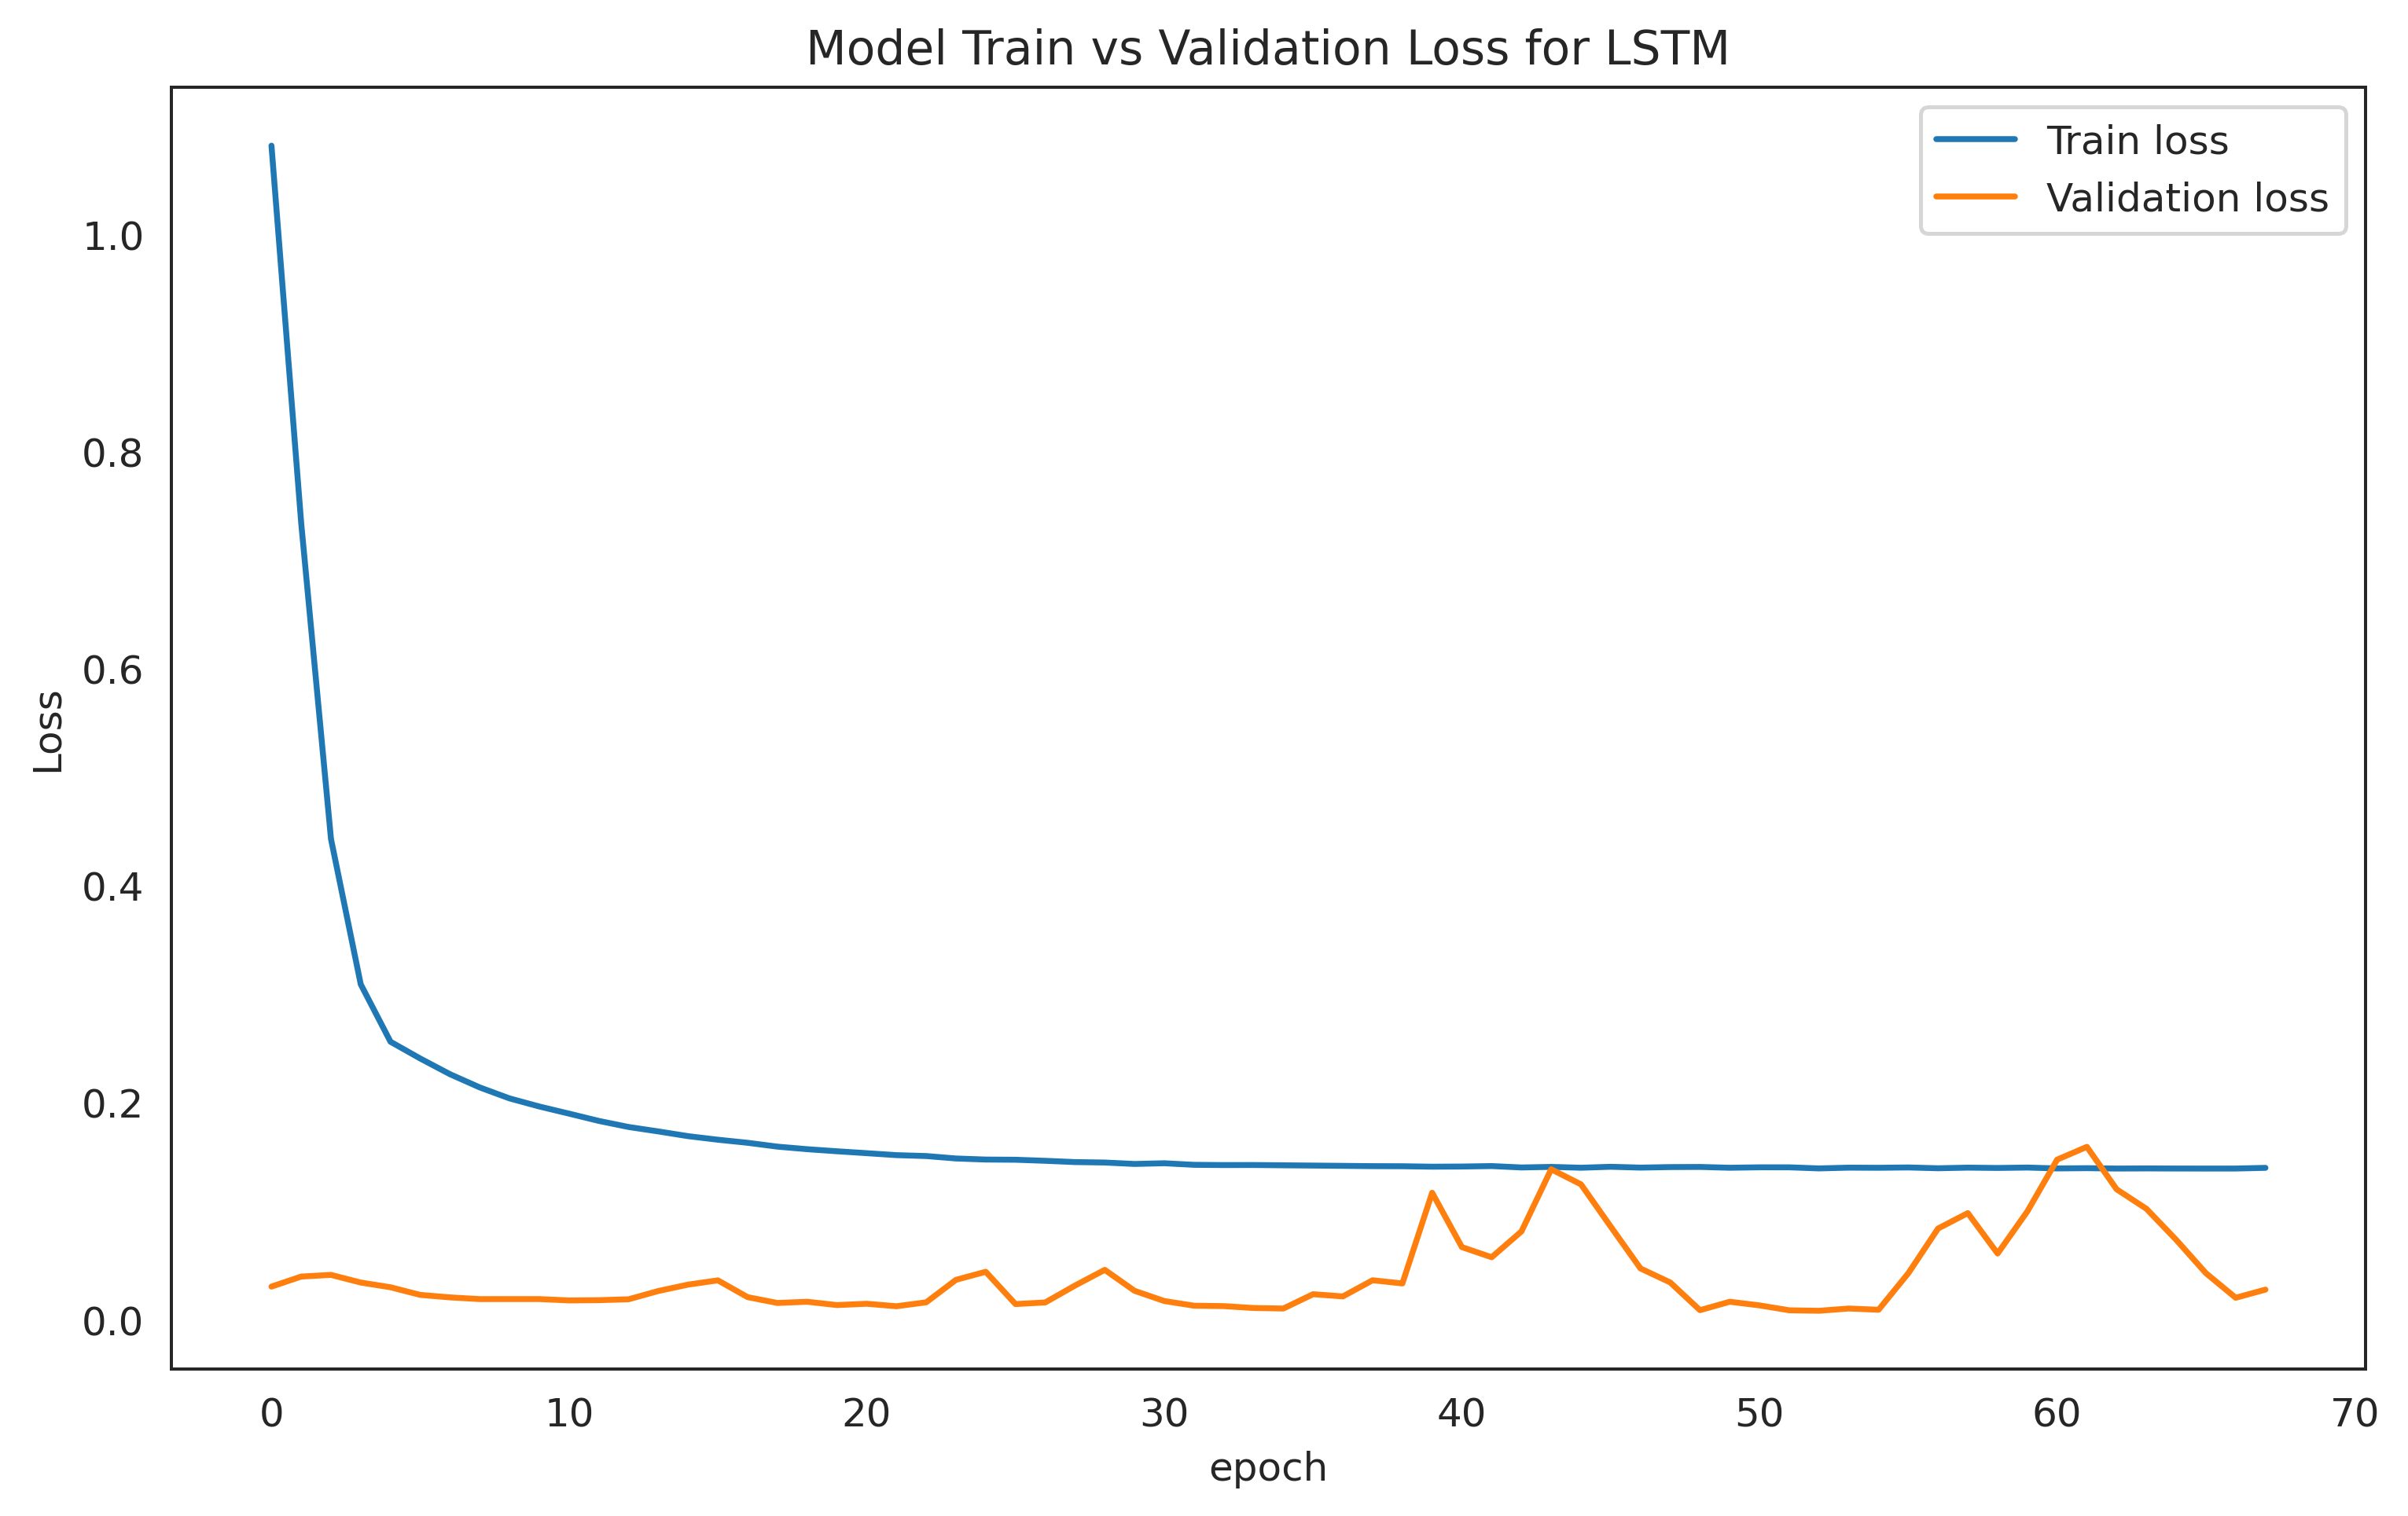

In [26]:
#Plot train and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_lstm, 'LSTM')

**Afte 30 epochs, the validation errors starts to rise, which is a sign of over fitting, therefore, one has to stop the training process at 30 epochs.**

In [27]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [28]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [29]:
prediction_LSTM = prediction(model_lstm)

In [30]:
## Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [31]:
evaluate_prediction(prediction_LSTM, y_test, 'LSTM')

LSTM:
Mean Absolute Error: 5863.3564
Root Mean Square Error: 7138.1261

